In [1]:
# Data gathered from World Bank, WHO
# Date: 6/16/2021
# Author: Timothy Lee

# Inspiration: 
# 'https://insight.kellogg.northwestern.edu/article/covid-19-death-rates-income-inequality' --> I found this article
# after some light web searching, was intrigued if I could replicate and come up with similar results that they presented.

# Project Goal: 
# I wanted to implement what I had taught myself into a real-world applicable scenario, and felt that it
# was appropriate to look into COVID, and its economic implications. I spent some time gathering data from reputable 
# sources, though I was limited with, such as the GINI index, which was slightly outdated. All in all, I felt that
# my analysis yielded results that were possible, though it was not constrained or realistic enough to make concrete
# assumptions with.


In [2]:
import pandas as pd
import country_converter as coco
import numpy as np
from numpy import percentile
from matplotlib import pyplot as plt

pd.options.display.max_rows = 20

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
countries_gdp = pd.read_csv('data/countries_gdp.csv', header=None)

countries_gdp = countries_gdp.drop(columns=[2, 3, 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64])

countries_gdp = countries_gdp.drop(index=[0, 1, 2, 3, 4])

countries_gdp.rename(columns={0:'country_name', 1:'country_code', 63:'gdp_2019'}, inplace=True)
countries_gdp.reset_index(drop=True, inplace=True)

In [4]:
per_cap = pd.read_csv('data/gdp_per_capita.csv', header=None)

per_cap = per_cap.drop(columns=[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62 ,64])

per_cap = per_cap.drop(index=[0, 1, 2, 3, 4])

per_cap = per_cap.rename(columns={0: 'country_name', 1: 'country_code', 63: 'per_capita_2019'})
per_cap.reset_index(drop=True, inplace=True)

In [5]:
#merging the country GDP and per capita GDP
gdp = pd.merge(countries_gdp, per_cap)

#dropping rows that don't have any GDP values
gdp = gdp.dropna(subset=['gdp_2019', 'per_capita_2019'], how='all')
gdp.reset_index(drop=True, inplace=True)

In [6]:
oecd_gini = pd.read_csv('data/gini_coefficients_oecd.csv')

oecd_gini.columns = oecd_gini.columns.str.replace(' ', '_')
oecd_gini.columns = map(str.lower, oecd_gini.columns)

oecd_gini = oecd_gini.drop(oecd_gini.loc[oecd_gini['subject'] != 'GINI'].index)

oecd_gini = oecd_gini.drop(columns=['frequency', 'flag_codes', 'indicator', 'measure', 'subject'])
oecd_gini.rename(columns={'location':'country_code', 'time':'year'}, inplace=True)

oecd_gini = oecd_gini.sort_values(['country_code', 'year'], ascending=False).groupby(['country_code']).first().reset_index()

oecd_gini['country_name'] = oecd_gini['country_code']
oecd_gini['country_name'] = coco.convert(names=oecd_gini['country_name'], to='name_short')


In [7]:
df = pd.merge(gdp, oecd_gini, 'outer')

In [8]:
df.dropna(subset=['year', 'value', 'gdp_2019', 'per_capita_2019'], how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns=['country_name'], inplace=True)

In [9]:
cases = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')

#making all column names lowercase
cases.columns = map(str.lower, cases.columns)

#only keeping most updated info and rows where cases != 0
cases = cases.drop(cases.loc[cases['date_reported'] != '2021-06-17'].index)
cases = cases.drop(cases.loc[cases['cumulative_cases'] == 0].index)

cases.reset_index(drop=True,inplace=True)

#dropping columns
cases.drop(columns=['who_region', 'new_cases', 'new_deaths', 'date_reported', 'country'], inplace=True)

#creating new column for fatality rate
cases['fatality_rate'] = cases['cumulative_deaths']
cases['fatality_rate'] = cases['fatality_rate'] / cases['cumulative_cases']

In [10]:
cases

country_code  cumulative_cases  cumulative_deaths  fatality_rate
0             AF             96531               3842       0.039801
1             AL            132476               2454       0.018524
2             DZ            134458               3598       0.026759
3             AD             13836                127       0.009179
4             AO             37094                847       0.022834
..           ...               ...                ...            ...
218           VN             11794                 61       0.005172
219           WF               454                  7       0.015419
220           YE              6867               1351       0.196738
221           ZM            118850               1492       0.012554
222           ZW             40556               1640       0.040438

[223 rows x 4 columns]

In [11]:
#ensuring there are no spaces/blanks in code
df['country_code'] = df['country_code'].str.strip()
cases['country_code'] = cases['country_code'].str.strip()

#convert 2 letter code in cases to a 3 letter code
cases['country_code'] = coco.convert(cases['country_code'], to='ISO3', not_found='not_found')

df = df.merge(cases, on='country_code', how='left')

XA not found in ISO2
nan not found in ISO3
 not found in regex
XC not found in ISO2
XB not found in ISO2


In [12]:
#adding rows for mean, median
df.loc['MEAN'] = df.mean()
df.loc['MEDIAN'] = df.median()

df.rename(columns={'value':'gini_co'}, inplace=True)

In [13]:
#for fatality rate, the lower the better so we look at 5th percentile
fatal_percentile = percentile(df['fatality_rate'], [5, 25, 50, 75, 95])

#for gini coefficient, the higher the better so we look at 75th percentile --> 95th is too high,
#thus likely includes countries with low population
gini_percentile = percentile(df['gini_co'], [25, 50, 75, 85])

#for per capita gdp, the higher the better therefore we look at the 85th percentile
#high enough to isolate countries, but still have a decently sized dataset
capita_percentile = percentile(df['per_capita_2019'], [25, 50, 75, 85])

capita_filt = df['per_capita_2019'] > capita_percentile[3]

In [14]:
fatal_percentile

array([0.00775845, 0.01281046, 0.01848117, 0.02691827, 0.04210993])

In [15]:
quartile_values = []

for index, row in df.iterrows():
    if(row['fatality_rate'] < fatal_percentile[0]):
        quartile_values.append(0.95) #95th percentile
    elif((row['fatality_rate'] > fatal_percentile[0]) & (row['fatality_rate'] < fatal_percentile[1])):
        quartile_values.append(0.75) #75th percentile
    elif((row['fatality_rate'] > fatal_percentile[1]) & (row['fatality_rate'] < fatal_percentile[2])):
        quartile_values.append(0.50) #50th percentile or median
    elif((row['fatality_rate'] > fatal_percentile[2]) & (row['fatality_rate'] < fatal_percentile[3])):
        quartile_values.append(0.25) #25th percentile
    elif((row['fatality_rate'] > fatal_percentile[3]) & (row['fatality_rate'] < fatal_percentile[4])):
        quartile_values.append(0.05) #5th percentile
    else:
        quartile_values.append(0.01)

df['fatal_percentile'] = quartile_values

In [16]:
#countries with gdp per capita in the 85th percentile
df.loc[capita_filt]

country_code      gdp_2019  per_capita_2019    year  gini_co  \
0           AUS  1.396570e+12      57183.37935  2018.0    0.325   
6           CHE  7.030820e+11      79402.50921  2017.0    0.299   
12          DNK  3.501040e+11      65867.00172  2017.0    0.264   
21          IRL  3.886990e+11      79823.01422  2017.0    0.295   
27          LUX  7.110492e+10     111043.53170  2018.0    0.318   
31          NOR  4.033360e+11      92556.32164  2018.0    0.262   
37          SWE  5.308840e+11      58050.01925  2018.0    0.275   

    cumulative_cases  cumulative_deaths  fatality_rate  fatal_percentile  
0            30291.0              910.0       0.030042              0.05  
6           698417.0            10266.0       0.014699              0.50  
12          290686.0             2527.0       0.008693              0.75  
21          267550.0             4979.0       0.018610              0.25  
27           70485.0              818.0       0.011605              0.75  
31          128498.0              790.0       0.006148              0.95  
37         1084601.0            14606.0       0.013467              0.50

In [17]:
#of those countries, average is the 53rd percentile in fatality rate
#average percentile among all polled countries is 25th, thus on average, those with high GDP per cap.
#have a lower fatality rate

#conclusion: higher standard of living may be a factor that lowers fatality rate for infectious diseases like COVID-19

df.loc[capita_filt]['fatal_percentile'].mean()

0.5357142857142857

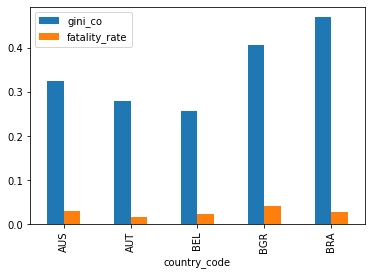

In [18]:
df.head().plot(x="country_code", y=["gini_co", "fatality_rate"], kind="bar")

In [19]:
#using pearson correlation
df.corr(method='pearson')

#From this we see that both per-capita gdp and the gini coefficient only have a low correlation with the fatality
#rate from contracting COVID-19. We must also understand that fatality from COVID can be associated to countless
#other factors such as population density and local/ government mask and social distancing enforcements.

gdp_2019  per_capita_2019      year   gini_co  \
gdp_2019           1.000000         0.010632 -0.364261  0.271458   
per_capita_2019    0.010632         1.000000  0.302519 -0.569405   
year              -0.364261         0.302519  1.000000 -0.583242   
gini_co            0.271458        -0.569405 -0.583242  1.000000   
cumulative_cases   0.604431        -0.148725 -0.441240  0.344167   
cumulative_deaths  0.582491        -0.187727 -0.411742  0.389064   
fatality_rate      0.139408        -0.410457 -0.177745  0.401020   
fatal_percentile  -0.127547         0.394257  0.100128 -0.319077   

                   cumulative_cases  cumulative_deaths  fatality_rate  \
gdp_2019                   0.604431           0.582491       0.139408   
per_capita_2019           -0.148725          -0.187727      -0.410457   
year                      -0.441240          -0.411742      -0.177745   
gini_co                    0.344167           0.389064       0.401020   
cumulative_cases           1.000000           0.929786      -0.022669   
cumulative_deaths          0.929786           1.000000       0.215056   
fatality_rate             -0.022669           0.215056       1.000000   
fatal_percentile          -0.049582          -0.202559      -0.710005   

                   fatal_percentile  
gdp_2019                  -0.127547  
per_capita_2019            0.394257  
year                       0.100128  
gini_co                   -0.319077  
cumulative_cases          -0.049582  
cumulative_deaths         -0.202559  
fatality_rate             -0.710005  
fatal_percentile           1.000000